In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

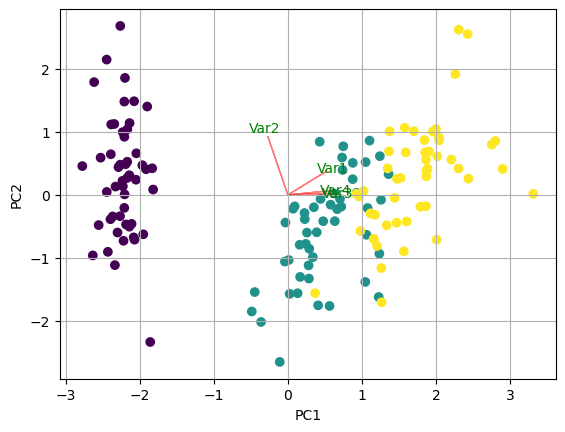

In [2]:
## basic iris data
iris = datasets.load_iris()
X = iris.data
y = iris.target

#In general it is a good idea to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
pca.fit(X,y)
x_new = pca.transform(X)   

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca.components_.T) 
plt.show()

In [81]:
### Ryan's code 

def prepare_df_rank(df, rank:str):
    '''takes in df_field containing all observations (28848), 
    and prepares a dataframe containing 16 rows (samples), and 
    col according to taxonomic rank
    '''
    df_rank = (df.groupby(['sample', rank, 'Lake', 'Edge', 'SampleType'], as_index=False)['Abundance'].sum()) 
    df_rank_wide = df_rank.pivot_table(
        index=['sample', 'Lake', 'Edge', 'SampleType'],  # HH added sample type 
        columns=rank,
        values='Abundance',
        fill_value=0  # fill missing abundance w/ 0
        ).reset_index()
    df_rank_wide.columns.name = None
    return df_rank_wide
###### 

df = pd.read_csv('microbe_data.csv')           # 28848 rows
df = df.iloc[:, 1:]                            # drop first col 
df = df[['taxonomy', 'sample', 'SampleType', 'Abundance', 'Lake', 'Edge']]    # keep relevant cols

# split columns according to taxa 
tax_split = df['taxonomy'].str.split(';', expand=True)
tax_split.columns = ['Root', 'domain', 'phylum', 'class', 'order']
for col in ['domain', 'phylum', 'class', 'order']:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpco]__', '', regex=True)
df = pd.concat([df, tax_split[['domain', 'phylum', 'class', 'order']]], axis=1)

df_phylum = prepare_df_rank(df, 'phylum') # 100 phylum 
df_class = prepare_df_rank(df, 'class')   # 246 phylum 
df_order = prepare_df_rank(df, 'order')   # 600 order 

In [51]:
#  define some columns 
sample = "sample"
lake = "Lake" 
lake_pos = "Edge" 
field = "SampleType"

In [52]:
def run_pca(df_taxa):
    '''takes in df output of prepare_df_rank and runs PCA analysis, 
    returns (a) fracvar, (b) pcs, (c) eigenvectors
    
    note that pca is run on a {m variable x n observations} matrix, where n = 16 (samples), and 
        - m = 100 for phylum 
        - m = 246 for class
        - m = 600 for order 
    
    there are 16 modes of variances (technically m modes, but python outputs min(m,n))
    each pc contains m elements, represents "taxa space"
    each eigenvector contains 16 elements, represents variations across samples 
    '''
    df_cols = df_taxa.columns.difference(['sample', 'Lake', 'Edge', 'SampleType']) # remove unnecessary cols for pca 
    X = df_taxa[df_cols].to_numpy() # shape: 16, m
    pca = PCA()                               
    PCs = pca.fit_transform(X)                                  
    eigvecs = pca.components_                       
    fracVar = pca.explained_variance_ratio_ 
    return fracVar, PCs, eigvecs

In [55]:
def run_pca_log(df_taxa, threshold = 0.35):
    '''similar to run_pca, but with additional preprocessing 
    1. keep only the relevant taxa (col) with >0 abudance in at least X% of samples 
    2. add pseudocount to zero values 
    3. transform data to a centered log-ratio (log, then subtract by sample mean)
        * idea here is to reflect how much more abundant a taxon is compared to the average of that sample
    4. standardize the data 
    '''
    # remove metadata from the df 
    meta_cols = ['sample', 'Lake', 'Edge', 'SampleType']  
    taxa_cols = df_taxa.columns.difference(meta_cols)
    X = df_taxa[taxa_cols].copy()        

    # keep taxa (col) that are found in at least 35% of samples  
    min_prev = max(1, int(np.ceil(threshold * X.shape[0])))       
    keep = (X > 0).sum(axis=0) >= min_prev
    X = X.loc[:, keep]

    # add pseudocount (for log later)
    pseudo = 1e-6
    X_pc = X + pseudo

    # centered log-ratio: log the data then subtract by sample mean (row)
    logX = np.log(X_pc)
    clr = logX.sub(logX.mean(axis=1), axis=0)  

    # standardize the data  
    scaler = StandardScaler(with_mean=True, with_std=True)
    clr_z = scaler.fit_transform(clr.values)  

    # run pca 
    pca = PCA() 
    PCs = pca.fit_transform(clr_z)                
    fracVar = pca.explained_variance_ratio_       
    eigvecs = pca.components_
    return fracVar, PCs, eigvecs

In [56]:
## PCA for phylum, order, class
fracVar_phylum, PCs_phylum, eigvecs_phylum = run_pca_log(df_phylum) # phylum
fracVar_class, PCs_class, eigvecs_class = run_pca_log(df_class) # class
fracVar_order, PCs_order, eigvecs_order = run_pca_log(df_order) # order

In [57]:
# Loadings 
def top_loadings(eigvecs, df_taxa): 
    ''' takes in the eigenvecs and df for phylum, order, class and returns eigenvecs (loadings) for the strongest taxa 
    contributing to PC1 and PC2 only 
    '''
    taxa_only = df_taxa.columns[4:]
    loadings = eigvecs.T 
    loading_strength = np.sum(np.abs(loadings[:, :2]), axis=1) # calculate the sum of the absolute eigvecs for PC1 and PC2
    # select all rows but up to the first two columns 
    k = 5 # select the top 5 taxa contributing to PC1 and PC2
    id_top = np.argsort(loading_strength)[-k:] #
    top_taxa = taxa_only[id_top]
    top_loadings = loadings[id_top, :]
    return top_taxa, top_loadings 

In [58]:
## top loadings for taxa RAW
top_phylum, phylum_loadings = top_loadings(eigvecs_phylum, df_phylum)
top_class, class_loadings = top_loadings(eigvecs_class, df_class)
top_order, order_loadings = top_loadings(eigvecs_order, df_order)

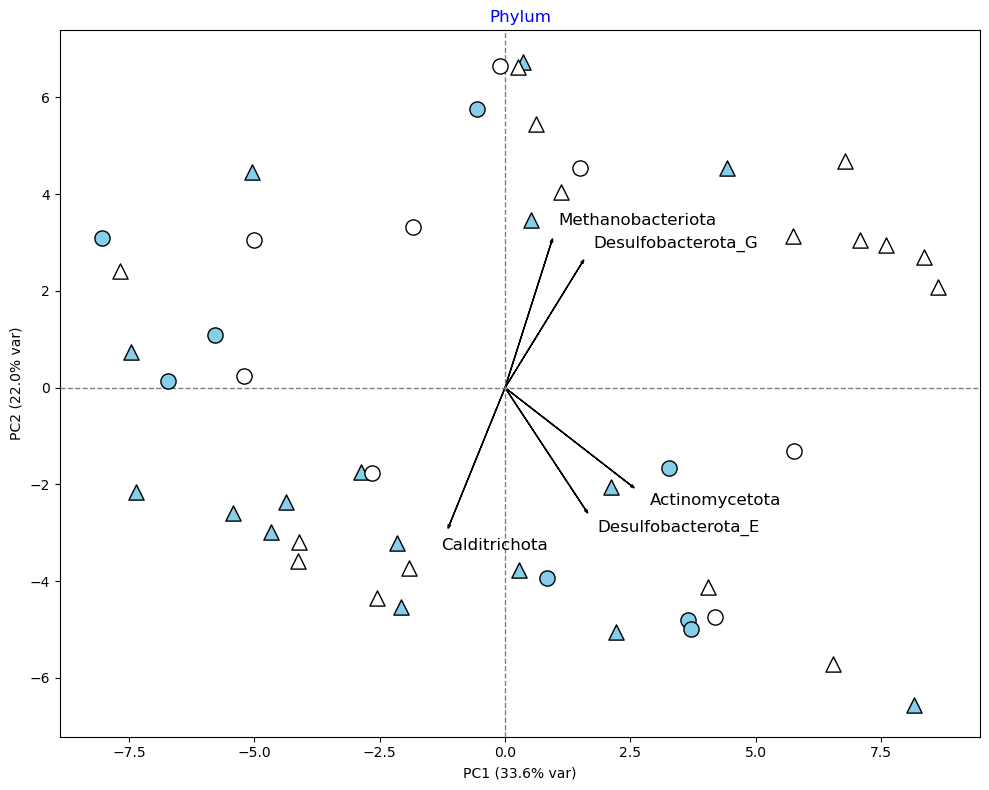

In [62]:
## PHYLUM PLOT
## Do edge/centre and field/incubation

# define mappings 
field_marker = {'Field': 'o', 'Incubation': '^'}
#lake_marker = {'Inre': 'o', 'Villa': '^'}
edge_color = {'Center': 'skyblue', 'Edge': 'white'}

#names = df_phylum[[field, lake_pos]].astype(str).agg("_".join, axis=1)

# plot for phylum 
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(df_phylum)):
    ax.scatter(
        PCs_phylum[i, 0],
        PCs_phylum[i, 1],
        s=120,
        marker=field_marker.get(df_phylum[field].iloc[i], 'o'),         # shape by field 
        facecolors=edge_color.get(df_phylum[lake_pos].iloc[i], 'gray'),   # color by edge
        edgecolors='black',                                # black outline
        linewidth=1,
        zorder=3, 
        #label = names.unique()
    )

# taxa vectors 
scalex = 1/ (PCs_phylum[:,0].max() - PCs_phylum[:,0].min()) # scale to PC1
scaley = 1/ (PCs_phylum[:,1].max() - PCs_phylum[:,1].min()) # scale to PC2

scalex
for i, taxon in enumerate(top_phylum):
    ax.arrow(0, 0,
             phylum_loadings[i, 0] / scalex,
             phylum_loadings[i, 1] / scaley,
             width=0.003,
             head_width=0.05)
    ax.text(phylum_loadings[i, 0] / scalex * 1.15,
            phylum_loadings[i, 1] / scaley * 1.15,
            taxon,
            fontsize=12,
            va = 'center')
    
# def biplot(score, coeff , y):
#     '''
#     Author: Serafeim Loukas, serafeim.loukas@epfl.ch
#     Inputs:
#        score: the projected data
#        coeff: the eigenvectors (PCs)
#        y: the class labels
#    '''
#     xs = score[:,0] # projection on PC1
#     ys = score[:,1] # projection on PC2
#     n = coeff.shape[0] # number of variables
#     plt.figure(figsize=(10,8), dpi=100)
#     classes = np.unique(y)
#     colors = ['g','r','y']
#     markers=['o','^','x']
#     for s,l in enumerate(classes):
#         plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
#     for i in range(n):
#         #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
#         plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

## axis labels 
ax.set_xlabel(f'PC1 ({fracVar_phylum[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({fracVar_phylum[1]*100:.1f}% var)')
ax.set_title('Phylum', color= 'b', fontsize=12)
#ax.legend()
ax.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
ax.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.savefig('phylumpca_log.png')

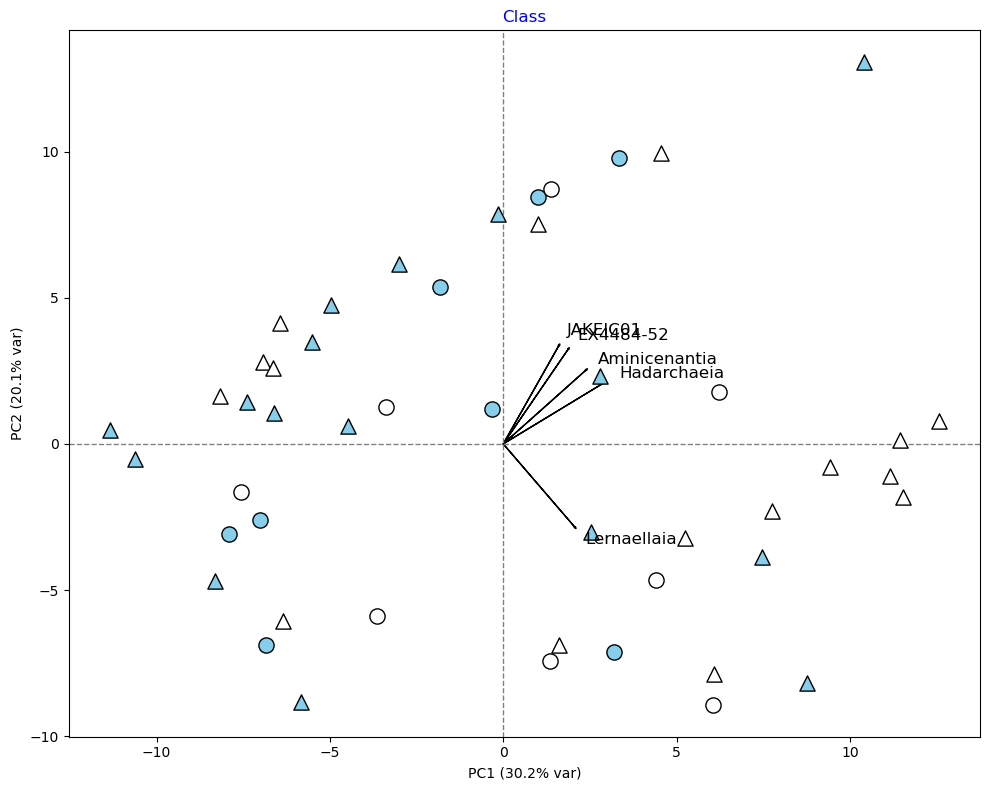

In [63]:
## CLASS PLOT
## Do edge/centre and field/incubation

#names = df_phylum[[field, lake_pos]].astype(str).agg("_".join, axis=1)

# plot for phylum 
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(df_class)):
    ax.scatter(
        PCs_class[i, 0],
        PCs_class[i, 1],
        s=120,
        marker=field_marker.get(df_class[field].iloc[i], 'o'),         # shape by field 
        facecolors=edge_color.get(df_class[lake_pos].iloc[i], 'gray'),   # color by edge
        edgecolors='black',                                # black outline
        linewidth=1,
        zorder=3, 
        #label = names.unique()
    )

# taxa vectors 
scalex = 1/ (PCs_class[:,0].max() - PCs_class[:,0].min()) # scale to PC1
scaley = 1/ (PCs_class[:,1].max() - PCs_class[:,1].min()) # scale to PC2

scalex
for i, taxon in enumerate(top_class):
    ax.arrow(0, 0,
             class_loadings[i, 0] / scalex,
             class_loadings[i, 1] / scaley,
             width=0.003,
             head_width=0.05)
    ax.text(class_loadings[i, 0] / scalex * 1.15,
            class_loadings[i, 1] / scaley * 1.15,
            taxon,
            fontsize=12,
            va = 'center')

## axis labels 
ax.set_xlabel(f'PC1 ({fracVar_class[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({fracVar_class[1]*100:.1f}% var)')
ax.set_title('Class', color= 'b', fontsize=12)
#ax.legend()
ax.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
ax.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.savefig('classpca_log.png')

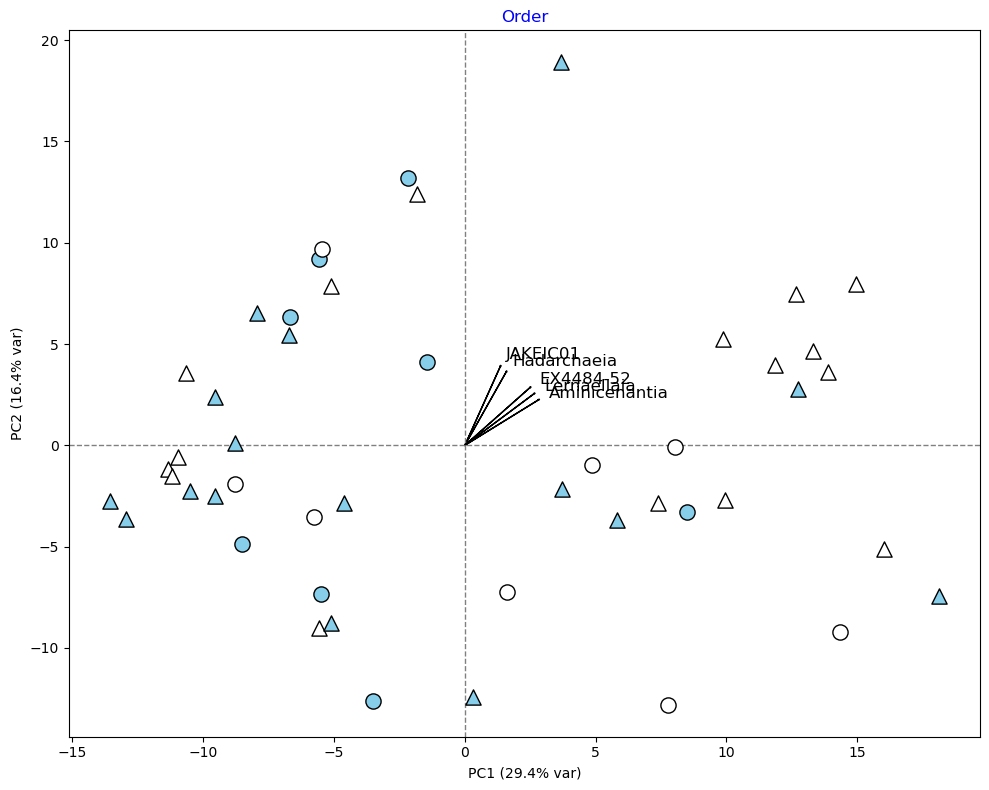

In [78]:
## ORDER PLOT
## Do edge/centre and field/incubation

#names = df_phylum[[field, lake_pos]].astype(str).agg("_".join, axis=1)

# plot for phylum 
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(df_order)):
    ax.scatter(
        PCs_order[i, 0],
        PCs_order[i, 1],
        s=120,
        marker=field_marker.get(df_order[field].iloc[i], 'o'),         # shape by field 
        facecolors=edge_color.get(df_order[lake_pos].iloc[i], 'gray'),   # color by edge
        edgecolors='black',                                # black outline
        linewidth=1,
        zorder=3, 
        #label = names.unique()
    )

# taxa vectors 
scalex = 1/ (PCs_order[:,0].max() - PCs_order[:,0].min()) # scale to PC1
scaley = 1/ (PCs_order[:,1].max() - PCs_order[:,1].min()) # scale to PC2

scalex
for i, taxon in enumerate(top_class):
    ax.arrow(0, 0,
             order_loadings[i, 0] / scalex,
             order_loadings[i, 1] / scaley,
             width=0.003,
             head_width=0.05)
    ax.text(order_loadings[i, 0] / scalex * 1.15,
            order_loadings[i, 1] / scaley * 1.15,
            taxon,
            fontsize=12,
            va = 'center')
    
## axis labels 
ax.set_xlabel(f'PC1 ({fracVar_order[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({fracVar_order[1]*100:.1f}% var)')
ax.set_title('Order', color= 'b', fontsize=12)
#ax.legend()
ax.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
ax.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.savefig('orderpca_log.png')